In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
from tqdm import tqdm
import uproot
import sys

sys.path.append('../../')
from pyanalib.pandas_helpers import *
from pyanalib.variable_calculator import *
import pyanalib.calo_helpers as caloh
from makedf.util import *
import pandas as pd
import numpy as np
from makedf.makedf import *
from makedf.util import *
from makedf.constants import *
from makedf.branches import *

plt.style.use("presentation.mplstyle")

In [6]:
testfile = "/exp/sbnd/data/users/munjung/xsec/NuINT2025/test_caf.root"
f = uproot.open(testfile)

In [7]:
CALO_PARAMS

{'alpha_emb': 0.848,
 'beta_90': 0.18799999999999997,
 'R_emb': 1.23,
 'c_cal_frac': [1.0, 1.0, 1.0],
 'etau': [100.0, 35.0]}

In [ ]:
trkdf = make_trkdf(f)

calo_params = CALO_PARAMS.copy()
calo_params_recomb = calo_params.copy()
alpha_unc = 0.008
beta_unc = 0.008
R_unc = 0.02
hdrdf = make_mchdrdf(f)
ismc = hdrdf.ismc.iloc[0]
for plane in range(0, 3):
    hitdf = make_trkhitdf(f, plane)

    trk_keys = trkdf.index.unique()
    hit_keys3 = hitdf.index.droplevel(-1)  # -1 since hitdf has an additional index
    mask_match = hit_keys3.isin(trk_keys)
    hitdf = hitdf[mask_match]
    
    this_etau = calo_params_recomb["etau"][1]
    if ismc:
        this_etau = calo_params_recomb["etau"][0]

    for alpha_sig in [-1, 0, 1]:
        for beta_sig in [-1, 0, 1]:
            for R_sig in [-1, 0, 1]:
        # for R_sig in tqdm([-3, -2, -1, 0, 1, 2, 3]):
        # alpha_sig = 0
        # beta_sig = 0
                # print("old_recomb_params", calo_params['alpha_emb'], calo_params['beta_90'], calo_params['R_emb'])
                calo_params_recomb["alpha_emb"] = calo_params["alpha_emb"] + alpha_sig * alpha_unc
                calo_params_recomb["beta_90"] = calo_params["beta_90"] + beta_sig * beta_unc
                calo_params_recomb["R_emb"] = calo_params["R_emb"] + R_sig * R_unc
                # print("new_recomb_params", calo_params_recomb["alpha_emb"], calo_params_recomb["beta_90"], calo_params_recomb["R_emb"])
                sign_tag = {3: "p3", 2: "p2", 1: "p1", 0: "cv", -1: "m1", -2: "m2", -3: "m3"}
                recomb_tag = "_A{}B{}R{}".format(sign_tag[alpha_sig],  sign_tag[beta_sig], sign_tag[R_sig])

                new_dedx = caloh.new_dedx(hitdf, calo_params_recomb["c_cal_frac"][plane], plane, calo_params_recomb["alpha_emb"], calo_params_recomb["beta_90"], calo_params_recomb["R_emb"], this_etau, ismc)
                hitdf[('dedx', '')] = new_dedx

                for par in ['muon', 'pion', 'proton']:
                    this_chi2_new = hitdf.groupby(level=['entry', 'rec.slc..index', 'rec.slc.reco.pfp..index']).apply(lambda group: caloh.calculate_chi2_for_entry(group, par))
                    this_chi2_new = this_chi2_new.apply(pd.Series).rename(columns={0: "chi2", 1: "ndof"})
                    this_chi2_col = ('pfp', 'trk', 'chi2pid', 'I' + str(plane), 'chi2_' + par + recomb_tag, '')
                    this_ndof_col = ('pfp', 'trk', 'chi2pid', 'I' + str(plane), 'ndof_' + par + recomb_tag, '')
                    trkdf[this_chi2_col] = this_chi2_new.chi2
                    trkdf[this_ndof_col] = this_chi2_new.ndof
                    trkdf[this_chi2_col] = trkdf[this_chi2_col].fillna(0.)
                    trkdf[this_ndof_col] = trkdf[this_ndof_col].fillna(0)

/exp/sbnd/app/users/munjung/xsec/cafpyana/analysis_village/numucc1p0pi/../../makedf/makedf.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.lasthit = df.lasthit.fillna(False)


# 뜯어보기

In [98]:
calo_params = CALO_PARAMS
calo_params_recomb = calo_params
alpha_unc = 0.008
beta_unc = 0.008
R_unc = 0.02
hdrdf = make_mchdrdf(f)
ismc = hdrdf.ismc.iloc[0]

print("old R_emb", calo_params["R_emb"])
R_new = calo_params["R_emb"] - R_unc
print("new R_emb", R_new)

plane = 2
hitdf = make_trkhitdf(f, plane)

trk_keys = trkdf.index.unique()
hit_keys3 = hitdf.index.droplevel(-1)  # -1 since hitdf has an additional index
mask_match = hit_keys3.isin(trk_keys)
hitdf = hitdf[mask_match]

this_etau = calo_params_recomb["etau"][1]
if ismc:
    this_etau = calo_params_recomb["etau"][0]
print("etau", this_etau)

calo_params_recomb["alpha_emb"] = calo_params["alpha_emb"]
calo_params_recomb["beta_90"] = calo_params["beta_90"]
calo_params_recomb["R_emb"] = calo_params["R_emb"]
recomb_tag = "_test"

new_dedx = caloh.new_dedx(hitdf, calo_params_recomb["c_cal_frac"][plane], plane, calo_params_recomb["alpha_emb"], calo_params_recomb["beta_90"], calo_params_recomb["R_emb"], this_etau, ismc)
hitdf[('dedx', '')] = new_dedx

# for par in ['muon', 'pion', 'proton']:
for par in ['proton']:
    this_chi2_new = hitdf.groupby(level=['entry', 'rec.slc..index', 'rec.slc.reco.pfp..index']).apply(lambda group: caloh.calculate_chi2_for_entry(group, par))
    this_chi2_new = this_chi2_new.apply(pd.Series).rename(columns={0: "chi2", 1: "ndof"})
    this_chi2_col = ('pfp', 'trk', 'chi2pid', 'I' + str(plane), 'chi2_' + par + recomb_tag, '')
    this_ndof_col = ('pfp', 'trk', 'chi2pid', 'I' + str(plane), 'ndof_' + par + recomb_tag, '')
    trkdf[this_chi2_col] = this_chi2_new.chi2
    trkdf[this_ndof_col] = this_chi2_new.ndof
    trkdf[this_chi2_col] = trkdf[this_chi2_col].fillna(0.)
    trkdf[this_ndof_col] = trkdf[this_ndof_col].fillna(0)

old R_emb 1.13
new R_emb 1.1099999999999999


/exp/sbnd/app/users/munjung/xsec/cafpyana/analysis_village/numucc1p0pi/../../makedf/makedf.py:164: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.lasthit = df.lasthit.fillna(False)


etau 100.0


/tmp/ipykernel_990975/1789161555.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trkdf[this_chi2_col] = this_chi2_new.chi2
/tmp/ipykernel_990975/1789161555.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trkdf[this_ndof_col] = this_chi2_new.ndof


In [99]:
calo_params

{'alpha_emb': 0.904,
 'beta_90': 0.204,
 'R_emb': 1.13,
 'c_cal_frac': [1.0, 1.0, 1.0],
 'etau': [100.0, 35.0]}

In [100]:
CALO_PARAMS

{'alpha_emb': 0.904,
 'beta_90': 0.204,
 'R_emb': 1.13,
 'c_cal_frac': [1.0, 1.0, 1.0],
 'etau': [100.0, 35.0]}

# Reproduction

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/core/shape_base.py:121: RuntimeWarning: invalid value encountered in cast
  ary = asanyarray(ary)


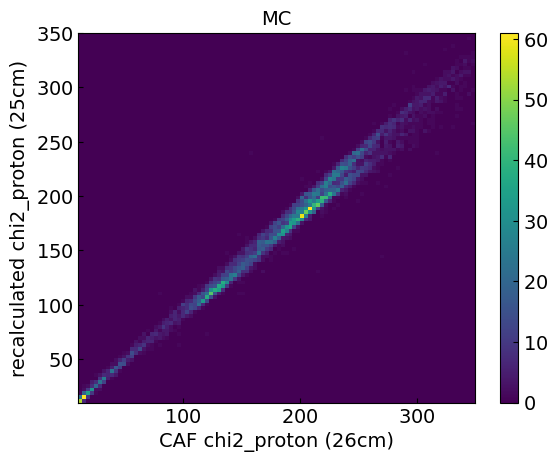

In [21]:
var1 = trkdf.pfp.trk.chi2pid.I0["chi2_proton"]
var2 = trkdf.pfp.trk.chi2pid.I0["chi2_proton_A{}B{}R{}".format("cv", "cv", "cv")]
plt.hist2d(var1, var2, bins=np.linspace(10, 350,101))
plt.xlabel("CAF chi2_proton (26cm)")
plt.ylabel("recalculated chi2_proton (25cm)")
plt.title("MC")
plt.colorbar()
plt.show();

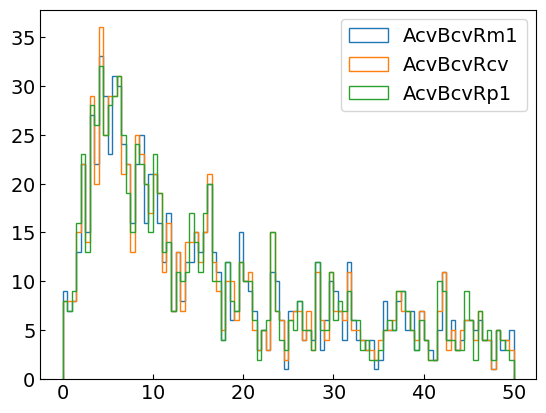

In [26]:
# for atag in ["m1", "cv", "p1"]:
for atag in ["cv"]:
    # for btag in ["m1", "cv", "p1"]:
    for btag in ["cv"]:
    # for btag in ["m1", "cv", "p1"]:
        for rtag in ["m1", "cv", "p1"]:
        # for rtag in ["cv"]:
            label = f"A{atag}B{btag}R{rtag}"
            var = trkdf.pfp.trk.chi2pid.I0["chi2_proton_A{}B{}R{}".format(atag, btag, rtag)]
            plt.hist(var, bins=np.linspace(1e-3, 50, 101), histtype="step", label=label)
# plt.legend(ncols=3, loc=(0.5, 2))
plt.legend()
plt.show();

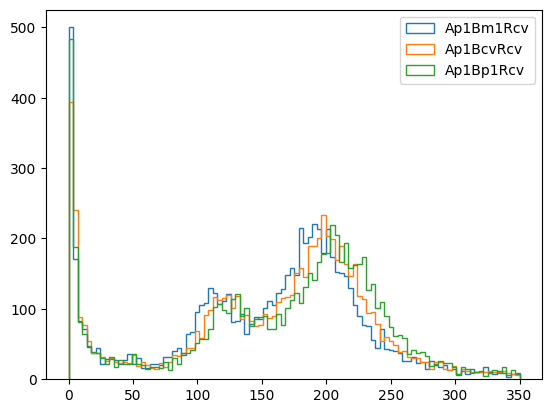

In [71]:
# for atag in ["m1", "cv", "p1"]:
#     for btag in ["m1", "cv", "p1"]:
for atag in ["p1"]:
    # for btag in ["cv"]:
    for btag in ["m1", "cv", "p1"]:
        # for rtag in ["m1", "cv", "p1"]:
        for rtag in ["cv"]:
            label = f"A{atag}B{btag}R{rtag}"
            var = trkdf.pfp.trk.chi2pid.I2["chi2_proton_A{}B{}R{}".format(atag, btag, rtag)]
            plt.hist(var, bins=np.linspace(1e-3, 350, 101), histtype="step", label=label)
plt.legend()
plt.show();

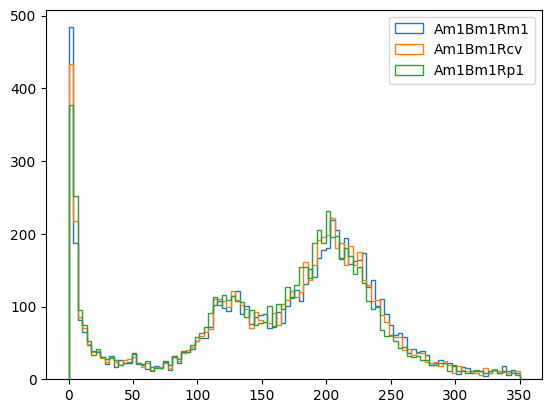

In [75]:
for atag in ["m1"]:
    for btag in ["m1"]:
    # for btag in ["m1", "cv", "p1"]:
        for rtag in ["m1", "cv", "p1"]:
        # for rtag in ["cv"]:
            label = f"A{atag}B{btag}R{rtag}"
            var = trkdf.pfp.trk.chi2pid.I2["chi2_proton_A{}B{}R{}".format(atag, btag, rtag)]
            plt.hist(var, bins=np.linspace(1e-3, 350, 101), histtype="step", label=label)
plt.legend()
plt.show();

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')


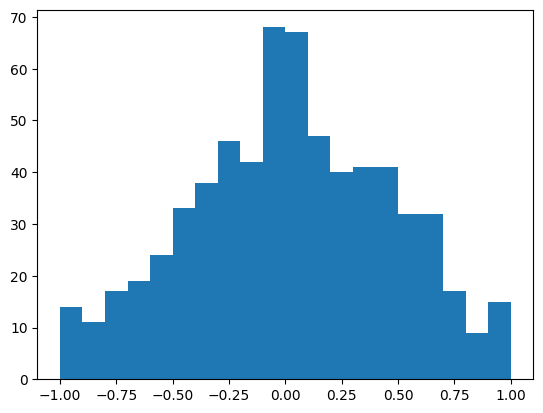

In [14]:
var = trkdf.pfp.trk.dir.x
plt.hist(var, bins=np.linspace(-1, 1, 21))
plt.show()